# Gerando sprites laterais com Pix2Pix

In [6]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import numpy as np

from matplotlib import pyplot as plt
from IPython import display

In [7]:
seed = 42
np.random.seed(seed)

data_folder = "tiny-hero"
batch_size = 128 
image_size = 64
channels = 4
noise_size = 100

Found 3648 files belonging to 4 classes.


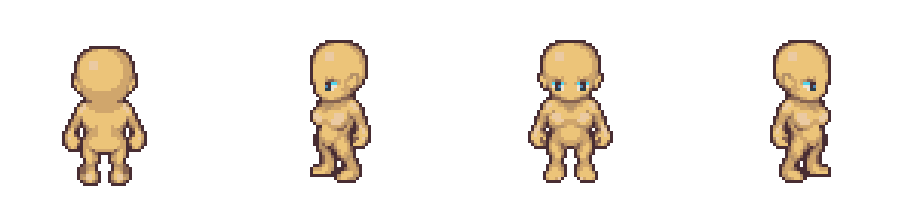

In [39]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_folder,
    color_mode="rgba",
    seed=seed,
    shuffle=False,
    image_size=(image_size, image_size),
    batch_size=batch_size)

dataset = dataset.unbatch()
back_dataset = dataset.filter(lambda x, l: tf.math.equal(l, tf.constant(0))).map(lambda x2, l2: tf.cast(x2, tf.float32))
left_dataset = dataset.filter(lambda x, l: tf.math.equal(l, tf.constant(1))).map(lambda x2, l2: tf.cast(x2, tf.float32))
front_dataset = dataset.filter(lambda x, l: tf.math.equal(l, tf.constant(2))).map(lambda x2, l2: tf.cast(x2, tf.float32))
right_dataset = dataset.filter(lambda x, l: tf.math.equal(l, tf.constant(3))).map(lambda x2, l2: tf.cast(x2, tf.float32))



def show_first_image(dataset, number, order):
    for image in dataset:
        plt.subplot(1, number, order)
        plt.imshow(image.numpy().astype("uint8"), interpolation="nearest")
        plt.axis("off")
        break
    
plt.figure(figsize=(16, 4))
show_first_image(back_dataset, 4, 1)
show_first_image(left_dataset, 4, 2)
show_first_image(front_dataset, 4, 3)
show_first_image(right_dataset, 4, 4)


In [43]:
BUFFER_SIZE = 3648
BATCH_SIZE = 1
IMG_SIZE = 64

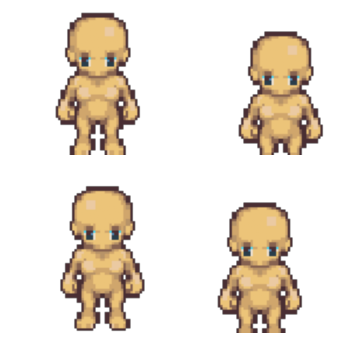

In [44]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_SIZE, IMG_SIZE, 4])
    return cropped_image[0], cropped_image[1]

# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 84x84
    input_image, real_image = resize(input_image, real_image, 84, 84)

    # Random cropping back to 64x64
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(next(iter(front_dataset)), next(iter(right_dataset)))
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
    plt.show()

In [60]:
def load_dataset_front_right():
    target_iterator = iter(right_dataset)
    for input_image in front_dataset:
        real_image = next(target_iterator)
        input_image, real_image = random_jitter(input_image, real_image)
        input_image, real_image = normalize(input_image, real_image)
        
        print(type(input_image))
        print(type(real_image))
        yield input_image, real_image

right_iterator = iter(right_dataset)
front_to_right_dataset = front_dataset.map(lambda x: (x, next(right_iterator)))


# front_to_right_dataset = front_to_right_dataset.shuffle(BUFFER_SIZE)
# front_to_right_dataset = front_to_right_dataset.batch(BATCH_SIZE)


In [63]:
OUTPUT_CHANNELS = 3
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

down_model = downsample(3, 4)
sample_input, sample_real = next(iter(front_to_right_dataset))
down_result = down_model(tf.expand_dims(sample_input, 0))
print (down_result.shape)

(1, 32, 32, 3)


In [62]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 64, 64, 3)


In [64]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()
gen_output = generator(sample_input[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

ValueError: Input 0 is incompatible with layer model: expected shape=(None, 256, 256, 3), found shape=(1, 64, 64, 4)